In [1]:
import spacy
nlp = spacy.blank('id')
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
import re
import string
nltk.download('punkt')

komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [7]:
from MeanVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [8]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [12]:
weights = y_train_enc
weights = np.choose(weights, [1, 1.2, 1.1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.  1.  1.2 ... 1.2 1.1 1.1] 

Ini y_train_encode
 [0 0 1 ... 1 2 2] 



In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000
    
param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

# param['num_class']=len(set(y))
# param['learning_rate'] = 0.001
# param['max_depth'] = 7
# param['min_child_weight'] = 10
# param['gamma'] = 2
# param['reg_alpha'] = 0.9
# param['reg_lambda'] = 4
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['objective'] = 'multi:softmax'
# param['scale_pos_weight'] = 1

watchlist = [(train, 'train'), (test, 'test')]
# num_round = 100
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.35026	test-merror:0.54414
[1]	train-merror:0.26826	test-merror:0.48957
[2]	train-merror:0.22435	test-merror:0.46549
[3]	train-merror:0.19460	test-merror:0.45907
[4]	train-merror:0.17564	test-merror:0.46549
[5]	train-merror:0.15998	test-merror:0.43820
[6]	train-merror:0.16324	test-merror:0.42376
[7]	train-merror:0.15222	test-merror:0.41734
[8]	train-merror:0.13773	test-merror:0.41091
[9]	train-merror:0.13334	test-merror:0.42376
[10]	train-merror:0.12591	test-merror:0.41573
[11]	train-merror:0.12445	test-merror:0.42857
[12]	train-merror:0.12079	test-merror:0.42376
[13]	train-merror:0.11874	test-merror:0.43018
[14]	train-merror:0.11446	test-merror:0.43499
[15]	train-merror:0.10930	test-merror:0.42857
[16]	train-merror:0.11157	test-merror:0.41573
[17]	train-merror:0.10908	test-merror:0.41413
[18]	train-merror:0.10579	test-merror:0.41894
[19]	train-merror:0.09957	test-merror:0.40449
[20]	train-merror:0.09532	test-merror:0.40610
[21]	train-merror:0.09741	test-merror:0.4028

[177]	train-merror:0.02997	test-merror:0.34350
[178]	train-merror:0.02997	test-merror:0.34350
[179]	train-merror:0.02957	test-merror:0.34350
[180]	train-merror:0.02957	test-merror:0.34350
[181]	train-merror:0.02997	test-merror:0.34029
[182]	train-merror:0.02913	test-merror:0.34350
[183]	train-merror:0.02997	test-merror:0.34510
[184]	train-merror:0.03041	test-merror:0.34510
[185]	train-merror:0.02997	test-merror:0.34510
[186]	train-merror:0.02953	test-merror:0.34671
[187]	train-merror:0.02916	test-merror:0.34350
[188]	train-merror:0.02741	test-merror:0.34350
[189]	train-merror:0.02862	test-merror:0.34350
[190]	train-merror:0.02821	test-merror:0.34189
[191]	train-merror:0.02905	test-merror:0.34189
[192]	train-merror:0.02825	test-merror:0.34189
[193]	train-merror:0.02712	test-merror:0.34189
[194]	train-merror:0.02836	test-merror:0.34029
[195]	train-merror:0.02792	test-merror:0.34510
[196]	train-merror:0.02708	test-merror:0.34510
[197]	train-merror:0.02631	test-merror:0.34510
[198]	train-m

[352]	train-merror:0.00758	test-merror:0.33868
[353]	train-merror:0.00758	test-merror:0.33708
[354]	train-merror:0.00721	test-merror:0.33868
[355]	train-merror:0.00721	test-merror:0.33868
[356]	train-merror:0.00721	test-merror:0.33868
[357]	train-merror:0.00721	test-merror:0.33708
[358]	train-merror:0.00681	test-merror:0.33708
[359]	train-merror:0.00717	test-merror:0.33868
[360]	train-merror:0.00717	test-merror:0.33868
[361]	train-merror:0.00681	test-merror:0.33868
[362]	train-merror:0.00717	test-merror:0.33708
[363]	train-merror:0.00717	test-merror:0.33547
[364]	train-merror:0.00717	test-merror:0.33547
[365]	train-merror:0.00717	test-merror:0.33547
[366]	train-merror:0.00717	test-merror:0.33547
[367]	train-merror:0.00717	test-merror:0.33547
[368]	train-merror:0.00717	test-merror:0.33387
[369]	train-merror:0.00681	test-merror:0.33387
[370]	train-merror:0.00681	test-merror:0.33387
[371]	train-merror:0.00681	test-merror:0.33547
[372]	train-merror:0.00681	test-merror:0.33226
[373]	train-m

[527]	train-merror:0.00359	test-merror:0.33547
[528]	train-merror:0.00359	test-merror:0.33547
[529]	train-merror:0.00359	test-merror:0.33387
[530]	train-merror:0.00359	test-merror:0.33387
[531]	train-merror:0.00359	test-merror:0.33387
[532]	train-merror:0.00359	test-merror:0.33547
[533]	train-merror:0.00359	test-merror:0.33547
[534]	train-merror:0.00359	test-merror:0.33547
[535]	train-merror:0.00359	test-merror:0.33387
[536]	train-merror:0.00359	test-merror:0.33547
[537]	train-merror:0.00359	test-merror:0.33547
[538]	train-merror:0.00359	test-merror:0.33547
[539]	train-merror:0.00359	test-merror:0.33547
[540]	train-merror:0.00359	test-merror:0.33708
[541]	train-merror:0.00359	test-merror:0.33387
[542]	train-merror:0.00359	test-merror:0.33387
[543]	train-merror:0.00359	test-merror:0.33387
[544]	train-merror:0.00359	test-merror:0.33547
[545]	train-merror:0.00359	test-merror:0.33547
[546]	train-merror:0.00315	test-merror:0.33547
[547]	train-merror:0.00315	test-merror:0.33387
[548]	train-m

[702]	train-merror:0.00117	test-merror:0.32905
[703]	train-merror:0.00117	test-merror:0.33066
[704]	train-merror:0.00117	test-merror:0.33226
[705]	train-merror:0.00117	test-merror:0.33387
[706]	train-merror:0.00117	test-merror:0.33387
[707]	train-merror:0.00117	test-merror:0.33066
[708]	train-merror:0.00117	test-merror:0.32905
[709]	train-merror:0.00117	test-merror:0.33226
[710]	train-merror:0.00117	test-merror:0.33387
[711]	train-merror:0.00117	test-merror:0.33387
[712]	train-merror:0.00117	test-merror:0.33226
[713]	train-merror:0.00117	test-merror:0.33226
[714]	train-merror:0.00117	test-merror:0.33387
[715]	train-merror:0.00117	test-merror:0.33226
[716]	train-merror:0.00117	test-merror:0.33226
[717]	train-merror:0.00117	test-merror:0.33387
[718]	train-merror:0.00117	test-merror:0.33387
[719]	train-merror:0.00117	test-merror:0.33387
[720]	train-merror:0.00117	test-merror:0.33226
[721]	train-merror:0.00117	test-merror:0.33066
[722]	train-merror:0.00117	test-merror:0.33066
[723]	train-m

[877]	train-merror:0.00037	test-merror:0.32745
[878]	train-merror:0.00037	test-merror:0.32745
[879]	train-merror:0.00037	test-merror:0.32584
[880]	train-merror:0.00037	test-merror:0.32584
[881]	train-merror:0.00037	test-merror:0.32584
[882]	train-merror:0.00037	test-merror:0.32745
[883]	train-merror:0.00037	test-merror:0.32745
[884]	train-merror:0.00037	test-merror:0.32745
[885]	train-merror:0.00037	test-merror:0.32745
[886]	train-merror:0.00037	test-merror:0.32745
[887]	train-merror:0.00037	test-merror:0.32745
[888]	train-merror:0.00037	test-merror:0.32905
[889]	train-merror:0.00037	test-merror:0.32905
[890]	train-merror:0.00037	test-merror:0.32905
[891]	train-merror:0.00037	test-merror:0.32905
[892]	train-merror:0.00037	test-merror:0.32745
[893]	train-merror:0.00037	test-merror:0.32745
[894]	train-merror:0.00037	test-merror:0.32745
[895]	train-merror:0.00037	test-merror:0.32424
[896]	train-merror:0.00037	test-merror:0.32424
[897]	train-merror:0.00037	test-merror:0.32584
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6741573033707865 

Train Score
 0.9995987158908507 

CONFUSSION MATRIX
 [[174  34  12]
 [ 38 118  44]
 [ 23  52 128]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.74      0.79      0.76       220
      netral       0.58      0.59      0.58       200
     positif       0.70      0.63      0.66       203

    accuracy                           0.67       623
   macro avg       0.67      0.67      0.67       623
weighted avg       0.67      0.67      0.67       623
 



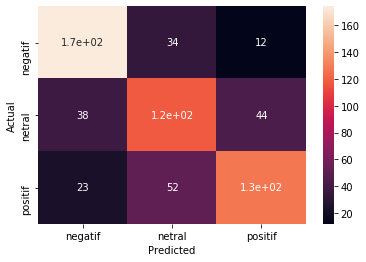

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])